# Image Operations

**Task**: perform broadcast and reduction operations on a tensor representing a batch of color images

**Goal**: The goal of this exercise was just to get used to thinking about shapes of multidimensional structures. A surprisingly large amount of the thinking that goes into implementing neural net code is getting the shapes right. I didn’t really believe that until I had to figure it out myself a couple of times, and that convinced me that everyone could use some guided practice with that.

# Setup

As usual, you don't need to understand the code in this section.

In [2]:
# Check versions of Keras and Tensorflow
!pip install -U keras einops
!pip list | egrep 'keras|tensorflow |jax '

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00
jax                                      0.4.23
jupyter-server-mathjax                   0.2.6
keras                                    3.0.5
keras-cv                                 0.8.2
keras-nlp                                0.8.1
keras-tuner                              1.4.6
tensorflow                               2.15.0
tf-keras                                 2.15.0


In [3]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
from keras import layers
import einops
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")

2024-03-02 16:01:03.716257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 16:01:03.716352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 16:01:03.836534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Keras version: 3.0.5, backend: jax


In [4]:
def show_image(image, ax=None, cmap='gray'):
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    img = np.array(image)
    context = {}
    if len(img.shape) == 2 or img.shape[2] == 1:
        # grayscale
        context = {'image.cmap': cmap}
    with matplotlib.rc_context(rc=context):
        ax.imshow(img.astype('uint8'))

def show_image_grid(images, titles=None, rows=None, cols=3, title_fontsize=8, figsize=(10, 10), cmap='gray'):
    if rows is None:
        rows = (len(images) + (cols - 1)) // cols

    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    # Turn off *all* axes (even those that we wouldn't show an image in)
    for ax in axs.flatten(): ax.axis('off')
    for i, ax in enumerate(axs.flatten()):
        if i >= len(images): break
        show_image(images[i], ax=ax, cmap=cmap)
        if titles is not None:
            ax.set_title(titles[i], fontsize=title_fontsize)

def get_images_from_dataset(dataset, indices):
    if hasattr(dataset, 'file_paths'):
        # FIXME: hardcoded options
        img_loader_opts = dict(target_size=(256, 256), keep_aspect_ratio=True)
        items_by_idx = {idx: keras.utils.load_img(dataset.file_paths[idx], **img_loader_opts) for idx in indices}
    else:
        items_by_idx = {idx: item for idx, (item, label) in enumerate(dataset.unbatch()) if idx in indices}
    return [items_by_idx[idx] for idx in indices]    

def channels_last_to_first(x):
    return einops.rearrange(x, 'b h w c -> b c h w')

### Configure

In [5]:
class config:
    seed = 123
    learning_rate = 1e-3
    epochs = 1
    batch_size = 16
    image_size = (256, 256)
    model_preset = "efficientnetv2_b0_imagenet"

# Reproducibility: Set a seed so that the results are the same every time this is run.
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
keras.utils.set_random_seed(config.seed)

### Load the data

We'll use a dataset of flower images for this example, but you can later switch this out for another dataset as long as you keep the file-and-folder structure.

The details of the code in this section are not important at this time; just run these cells.

In [6]:
path_to_downloaded_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    extract=True,
)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Let's see what just got downloaded.

In [7]:
data_path = Path(path_to_downloaded_file).parent / 'flower_photos'
!ls {data_path}

LICENSE.txt  daisy  dandelion  roses  sunflowers  tulips


We'll use a Keras utility function to load the data. [Docs](https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function)



In [8]:
# Define which classes we want to use, in what order.
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Create training and validation datasets
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    labels='inferred',
    class_names=class_names,
    label_mode='int',
    batch_size=config.batch_size,
    image_size=config.image_size,
    shuffle=True,
    seed=128,
    subset='both',
    crop_to_aspect_ratio=True   
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


Let's show some example images.

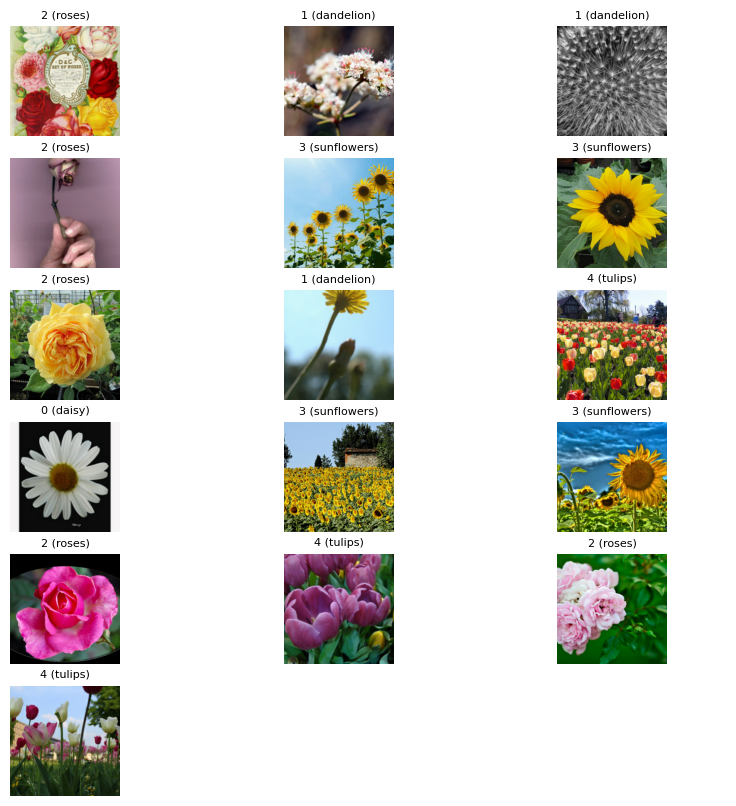

In [9]:
[[images, labels]] = train_dataset.take(1)
images = images.numpy()
labels = labels.numpy()
show_image_grid(
    images,
    titles=[f"{label} ({class_names[label]})" for label in labels])

# Task

Note: *all of these operations are one-liners*. If you find yourself writing lots of code, pause and think more (or ask for help).

1. **Evaluate `images.shape`**. What does each number represent?

In [10]:
images.shape

(16, 256, 256, 3)

The first number represent the batch size. There are 16 in each batch.

The second number represent each image height in pixels.

The third number represent each image width in pixels.

The fourth number represent the amount of color channels in each image.

2. **Evaluate `labels`**. Explain those numbers, with the help of `class_names`.

In [11]:
labels

array([2, 1, 1, 2, 3, 3, 2, 1, 4, 0, 3, 3, 2, 4, 2, 4], dtype=int32)

In [12]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']



- Image 1: roses
- Image 2: dandelion
- Image 3: dandelion
- Image 4: roses
- Image 5: tulips
- Image 6: tulips
- Image 7: roses
- Image 8: dandelion
- Image 9: sunflowers
- Image 10: daisy
- Image 11: tulips
- Image 12: tulips
- Image 13: roses
- Image 14: sunflowers
- Image 15: roses
- Image 16: sunflowers

3. **Show the first image in the batch.** (Use `show_image`.)

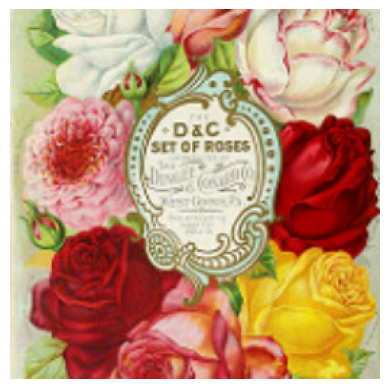

In [13]:
show_image(images[0])

4. **Show the average image.** Hint: you can compute this by taking the `.mean(axis=___)`; think about what the blank is.

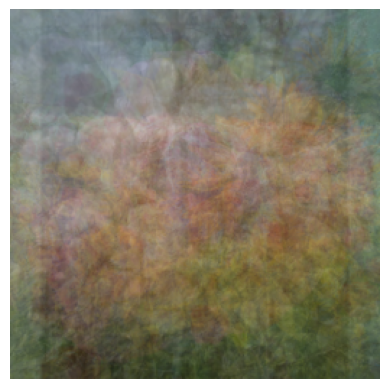

In [14]:
avg_image = np.mean(images, axis=0)
show_image(avg_image)

5. Show the average of the **middle 3 images.**

You'll need to use *slicing* to compute this. (To make sure you're doing it right, first *show the middle 3 images* using `show_image_grid`.)

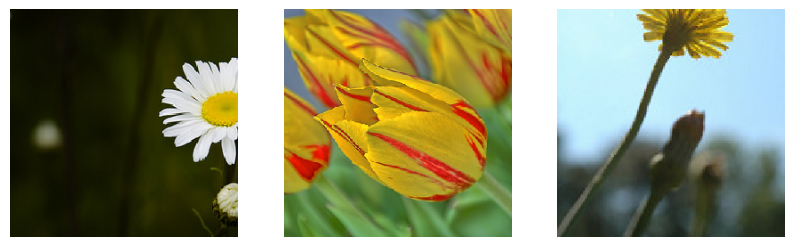

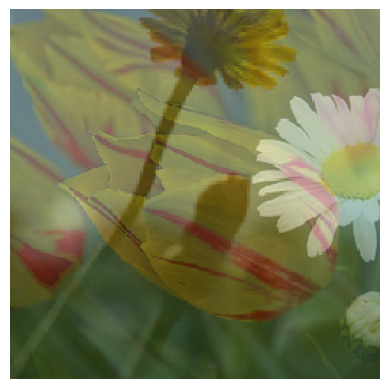

In [15]:
# Slice 
mid_i = range(len(images)//2 - 1, len(images)//2 + 2)
mid_images = get_images_from_dataset(train_dataset, mid_i)
show_image_grid(mid_images)
plt.show()

# Computation
mid_array = np.array(mid_images)
avg_mid_image = np.mean(mid_array, axis=0)

# Average Image
show_image(avg_mid_image)


6. **Show the grayscale version of all of the images.**

- *Do this by making minimal changes to the previous exercise; do not import anything new.*
- For simplicity, just use an equal weighting of the red, green, and blue channels, i.e., take the `mean` across channels.
- You can use `show_image_grid` to show all of the images.

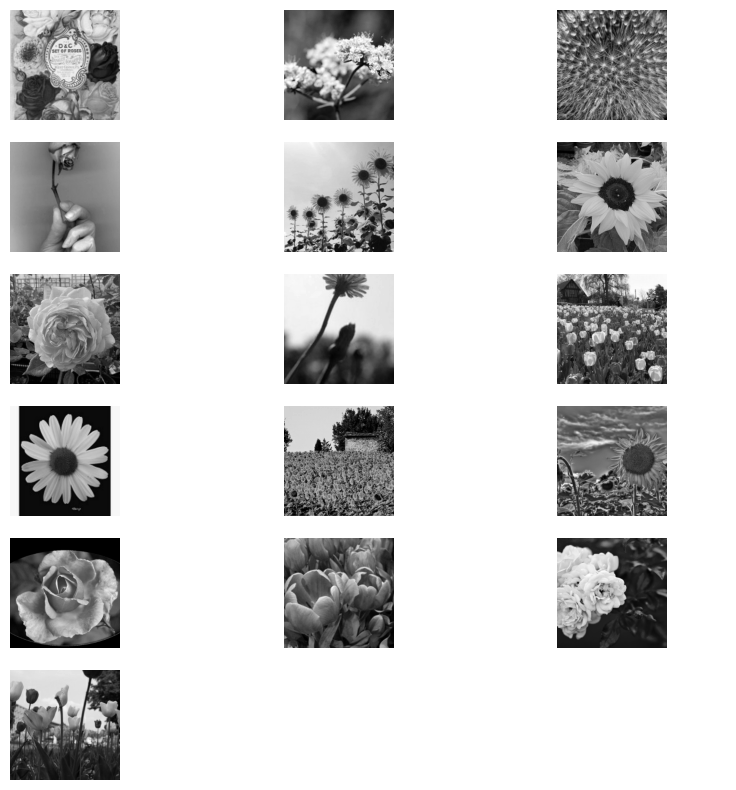

In [16]:
grayscale_images = np.mean(images, axis=-1)

show_image_grid(grayscale_images)

7. **Invert the color of the grayscale images** (e.g., black becomes white). Show the result.

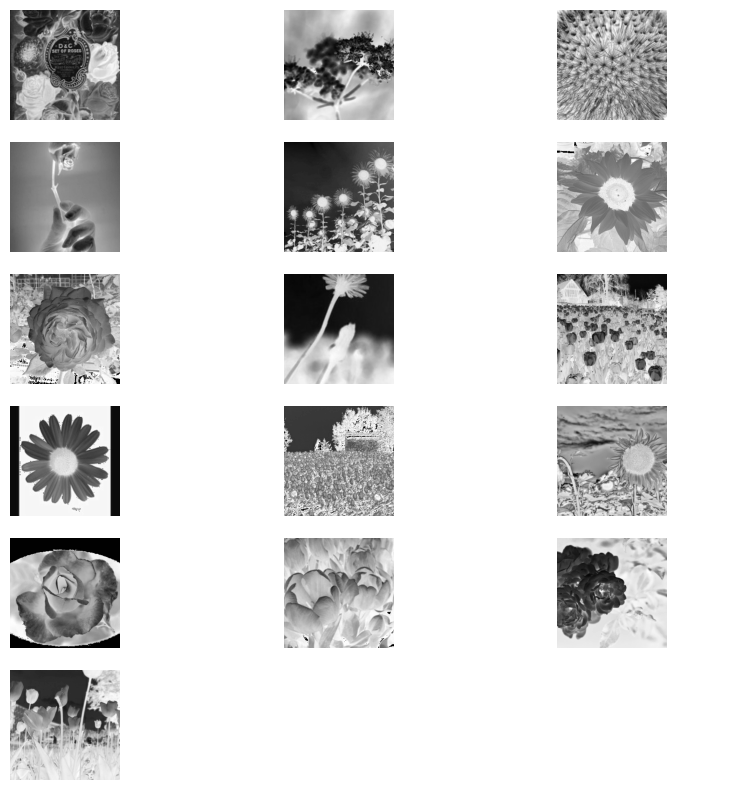

In [17]:
inverted_images = 1 - grayscale_images

show_image_grid(inverted_images)

## Convolution layers

We'll set up a demonstration convolution layer that we can poke at:

In [18]:
demo_conv_layer = layers.Conv2D(filters=5, kernel_size=(4, 4))

We'll try running it on a sample image. Since conv layers are designed to run on batches, we'll need to add a "batch" dimension to the image. We can do this using the `expand_dims` function, which adds a new dimension of size 1 at the specified position. Or we just use slicing syntax.

In [30]:
example_image = images[5]
example_image_as_batch = images[5:9]
# alternative: example_image_as_batch = np.expand_dims(example_image, axis=0)
example_image_as_batch.shape

(4, 256, 256, 3)

Now we give that image batch to the conv layer. Predict what you think the output shape will be, and then check your answer by running the code.

In [20]:
demo_conv_activations = demo_conv_layer(example_image_as_batch)
demo_conv_activations.shape

(2, 252, 252, 4)

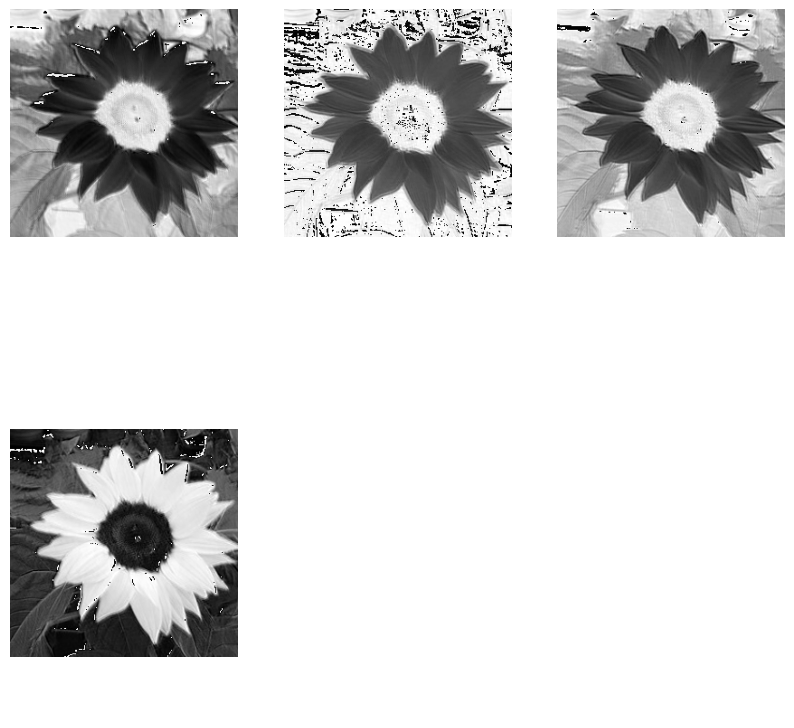

In [21]:
show_image_grid(
    channels_last_to_first(demo_conv_activations)[0])

Finally, let's look at the weights of the conv layer. What shape do you expect them to be? Check your answer by running the code.

In [22]:
w, b = demo_conv_layer.get_weights()
print(w.shape)
print(b.shape)

(5, 5, 3, 4)
(4,)


**Your turn**:

1. For each number in the shape of the *activations*, explain what it represents.
2. For each number in the shape of the *weightss*, explain what it represents.
3. For each of those numbers above, change something about the code above so that that number changes (or explain why you can't). Explain the changes you made.

1. The first number (1) indicates the batch size. The second (252) indicates the height of the activations tensor after applying the convolution operation. The third number (252) indicates the width of the activations tensor. The fourth number (4) indicates the number of filters produced by the convolutional layer. 

2. The first number (5) indicates the height of the kernel tensor whereas the second number (5) indicates the width. The third number (3) indicates the number of channels in the input tensor to the convolutional layer. The fourth number (4) indicates the number of filters (or channels) in the output tensor.

3. 
* I modify the batch size code by changing it from example_image_as_batch = images[5:6] to example_image_as_batch = images[5:9]. Which increases 3 of the batch size. 
* Another change that I made was modifying the kernel size from demo_conv_layer = layers.Conv2D(filters=4, kernel_size=(5, 5))to demo_conv_layer = layers.Conv2D(filters=4, kernel_size=(4, 4)).
* I was able to also modify the number of filters in the activations by changing demo_conv_layer = layers.Conv2D(filters=4, kernel_size=(4, 4)) to demo_conv_layer = layers.Conv2D(filters=5, kernel_size=(4, 4)).
* I wasn't able to change the number of input channels in the weights. I think the reason for this might be because the filter in the input images that would needed to be change to which require downloading new images.

## A real conv layer

Let's just look at what a real conv layer does. We'll load the pretrained backbone that we used in prior homeworks, find its first conv layer, and run it on the same image.

Fist, loading the model:

In [23]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

model.backbone.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...


Model: "efficient_net_v2b0_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_conv (Conv2D)              │ (None, None, None, 32) │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_bn (BatchNormalization)    │ (None, None, None, 32) │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_activation (Activation)    │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1a_ (FusedMBConvBlock)     │ (None, None, None, 16) │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2a_ (FusedMBConvBlock)     │ (None, None, None, 32) │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2b_ (FusedMBConvBlock)     │ (None, None, None, 32) │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3a_ (FusedMBConvBlock)     │ (None, None, None, 48) │        43,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3b_ (FusedMBConvBlock)     │ (None, None, None, 48) │        93,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4a_ (MBConvBlock)          │ (None, None, None, 96) │        36,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4b_ (MBConvBlock)          │ (None, None, None, 96) │        99,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4c_ (MBConvBlock)          │ (None, None, None, 96) │        99,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5a_ (MBConvBlock)          │ (None, None, None,     │       158,296 │
│                                 │ 112)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5b_ (MBConvBlock)          │ (None, None, None,     │       200,732 │
│                                 │ 112)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5c_ (MBConvBlock)          │ (None, None, None,     │       200,732 │
│                                 │ 112)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5d_ (MBConvBlock)          │ (None, None, None,     │       200,732 │
│                                 │ 112)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5e_ (MBConvBlock)          │ (None, None, None,     │       200,732 │
│                                 │ 112)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block6a_ (MBConvBlock)          │ (None, None, None,     │       254,812 │
│                                 │ 192)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block6b_ (MBConvBlock)          │ (None, None, None,     │       574,512 │
│                                 │ 192)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block6c_ (MBConvBlock)          │ (None, None, None,     │       574,512 │
│                                 │ 192)                   │             

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,858,704 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

The first layer rescales the input from [0, 255] to [0, 1].

In [24]:
1/model.backbone.layers[1].scale

255.0

Right after that is the first conv layer:

In [25]:
first_conv = model.backbone.layers[2]
w, = first_conv.get_weights()
w.shape

(3, 3, 3, 32)

Let's try it on our example images. We'll manually rescale before and after, to make sure we're doing the same thing as the model.

In [26]:
first_conv_out = first_conv(images / 255.0)
first_conv_out.shape

(16, 128, 128, 32)

You might be confused by the output shape: why is it 128x128? That's because it's using *strided* convolutions, which we haven't talked about yet. Basically it means that only every other output is kept. Also, padding='same', so no pixels are lost on the borders.

In [27]:
first_conv.strides, first_conv.padding

((2, 2), 'same')

So what's it look like? Let's visualize the output.

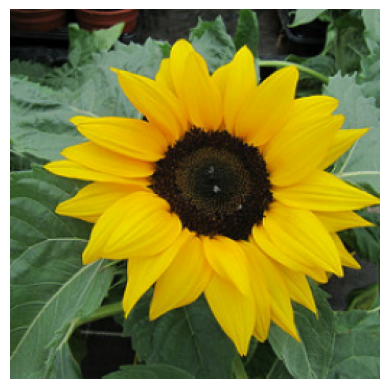

In [28]:
show_image(images[5])

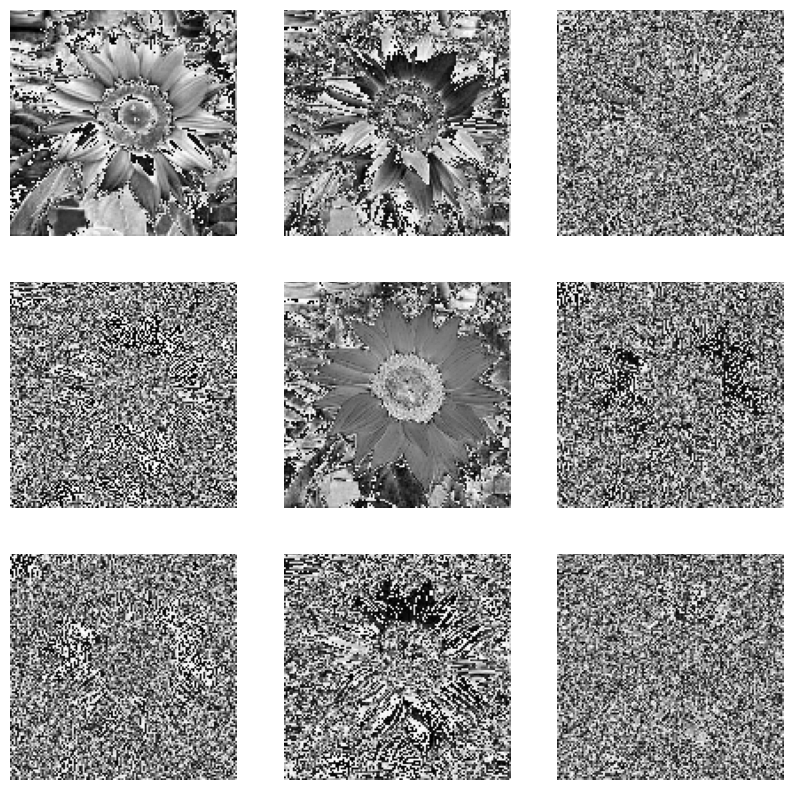

In [29]:
show_image_grid(
    channels_last_to_first(first_conv_out)[5][:9] * 255.0)

**Analysis**: In the `summary` table above, find this first convolution layer. Note the `Param #` column. Write an expression that evaluates to the number of parameters in this layer (864).

3 * 3 * 3 * 32 + 32 = 864